In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

print('=3')

=3


In [2]:
# 다운로드에 매우 긴 시간이 소요됩니다. 
import urllib3
urllib3.disable_warnings()

data_dir = os.path.join(os.getenv("HOME"), "aiffel/object_detection/data")

(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=data_dir,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

print('=3')

=3


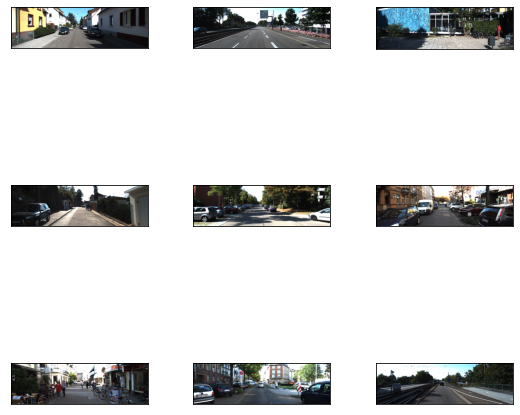

In [3]:
_ = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(7,), dtype=float32, numpy=array([-1.37, -1.88, -1.77,  1.7 , -1.63, -1.6 , -2.23], dtype=float32)>, 'bbox': <tf.Tensor: shape=(7, 4), dtype=float32, numpy=
array([[0.24994667, 0.2973108 , 0.52168   , 0.40366346],
       [0.17834666, 0.6147907 , 0.5295733 , 0.7669726 ],
       [0.28474668, 0.56700486, 0.51584   , 0.660314  ],
       [0.40186667, 0.36808375, 0.6414667 , 0.43763286],
       [0.41714665, 0.53014493, 0.526     , 0.56913847],
       [0.46928   , 0.501715  , 0.5439467 , 0.5234461 ],
       [0.00266667, 0.7391385 , 0.5110667 , 0.99919486]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(7, 3), dtype=float32, numpy=
array([[1.65, 1.67, 3.81],
       [1.52, 1.51, 3.1 ],
       [1.53, 1.58, 3.53],
       [2.6 , 2.06, 5.42],
       [1.46, 1.6 , 3.71],
       [1.97, 1.82, 4.41],
       [1.57, 1.72, 3.52]], dtype=float32)>, 'location': <tf.Tensor: shape=(7, 3), dtype=float

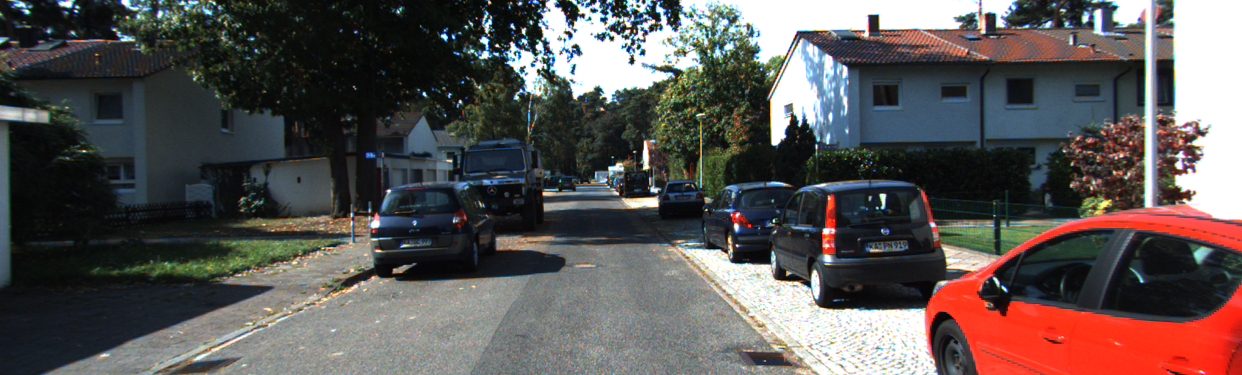

In [5]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

width: 1242  height: 375
(7, 4)
[369.26 281.27 501.35 179.37]
[763.57    308.12    952.57996 176.41   ]
[704.22003 268.22    820.11005 181.56   ]
[457.16    224.3     543.54004 134.45   ]
[658.44    218.57    706.87    177.74998]
[623.13007 199.02    650.12006 171.01999]
[ 918.01     374.      1241.       183.34999]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7FB4904952D0>


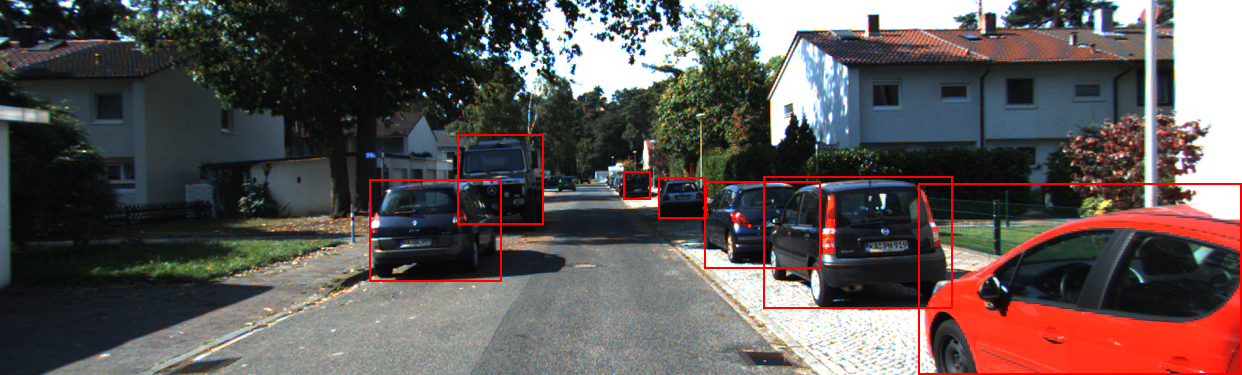

In [6]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

In [7]:
import os
data_dir = os.getenv('HOME') + '/aiffel/object_detection/data'
img_dir = data_dir + '/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir, total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        
        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height
        
        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            
    return df
        
df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',', index=False, header=False)

100%|██████████| 6347/6347 [22:23<00:00,  4.72it/s]


In [8]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',', index=False, header=False)

100%|██████████| 711/711 [02:35<00:00,  4.57it/s]


In [9]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")
    print('Done')
            
save_class_format(class_txt_path)

Done


In [12]:
# RetinaNet 훈련이 시작됩니다!! 10epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 10 --steps 195 csv data/kitti_train.csv data/classes.txt
print("Done")

2021-10-13 01:08:09.897226: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-10-13 01:08:09.897271: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-10-13 01:08:11.448429: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-10-13 01:08:11.456368: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-10-13 01:08:11.456503: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcud

res4c_relu (Activation)         (None, None, None, 1 0           res4c[0][0]                      
__________________________________________________________________________________________________
res4d_branch2a (Conv2D)         (None, None, None, 2 262144      res4c_relu[0][0]                 
__________________________________________________________________________________________________
bn4d_branch2a (BatchNormalizati (None, None, None, 2 1024        res4d_branch2a[0][0]             
__________________________________________________________________________________________________
res4d_branch2a_relu (Activation (None, None, None, 2 0           bn4d_branch2a[0][0]              
__________________________________________________________________________________________________
padding4d_branch2b (ZeroPadding (None, None, None, 2 0           res4d_branch2a_relu[0][0]        
__________________________________________________________________________________________________
res4d_bran

Epoch 1/10
195/195 [==============================] - ETA: 0s - loss: 3.2646 - regression_loss: 2.6109 - classification_loss: 0.6537
Epoch 00001: saving model to ./snapshots/resnet50_csv_01.h5
195/195 [==============================] - 1364s 7s/step - loss: 3.2646 - regression_loss: 2.6109 - classification_loss: 0.6537
Epoch 2/10
195/195 [==============================] - ETA: 0s - loss: 2.4575 - regression_loss: 2.1178 - classification_loss: 0.3397
Epoch 00002: saving model to ./snapshots/resnet50_csv_02.h5
195/195 [==============================] - 1364s 7s/step - loss: 2.4575 - regression_loss: 2.1178 - classification_loss: 0.3397
Epoch 3/10
195/195 [==============================] - ETA: 0s - loss: 2.0995 - regression_loss: 1.8213 - classification_loss: 0.2782
Epoch 00003: saving model to ./snapshots/resnet50_csv_03.h5
195/195 [==============================] - 1357s 7s/step - loss: 2.0995 - regression_loss: 1.8213 - classification_loss: 0.2782
Epoch 4/10
195/195 [=================

In [21]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_10.h5 snapshots/resnet50_csv_10_infer.h5
print("Done")

2021-10-13 05:05:07.962762: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-10-13 05:05:07.962807: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-10-13 05:05:09.439151: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-10-13 05:05:09.446850: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-10-13 05:05:09.446971: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcud

In [23]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


OSError: SavedModel file does not exist at: /aiffel/aiffel/object_detection/snapshots/resnet50_csv_50_infer.h5/{saved_model.pbtxt|saved_model.pb}

In [24]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path="./test_set/go_1.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path=img_path)

NameError: name 'model' is not defined

In [25]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path)

NameError: name 'model' is not defined

In [26]:
def self_drive_assist(model, img_path, size_limit=300, visualize=True):
    result = "Go"
    image = read_image_bgr(img_path)
    
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
    color_map = {
        0:(0,0,255),
        1:(255,0,0)
    }
    
    # 이미지 전처리
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    # peocess image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    
    # correct for image scale
    boxes /= scale
    
    # display images
    if visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score<0.5:
                break
            b = box.astype(int)
            
            if b[1]-b[0] >= 300 or b[2]-b[0] >= 300 or label == 1 :
                result = 'Stop'
            else:
                result = 'Go'

            draw_box(draw, b, color=color_map[label])
            
            caption = "{:3f}".format(score)
            draw_caption(draw, b, caption)
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.title(result, fontsize=20)
        plt.imshow(draw)
        plt.show()
    
        return result

In [27]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        print(image_path)
        pred = self_drive_assist(model=model, img_path=image_path, visualize=True)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

In [28]:
test_system(self_drive_assist)

/aiffel/aiffel/object_detection/test_set/stop_1.png


NameError: name 'model' is not defined